# Desafio Detecção de objetos pequenos usando YOLO
Vou usar esse notebook como rascunho para os códigos e testá-los também.

Links de Apoio:
- [YOLOv8 GitHub](https://github.com/ultralytics/ultralytics)
- [Ultralytics docs](https://docs.ultralytics.com/)
- Datasets e Modelos: [Roboflow](https://huggingface.co/), [Hugging Face](https://huggingface.co/)

## Códigos de início e teste

In [ ]:
# Teste pra ver se ta tudo funcionando

from ultralytics import YOLO

model = YOLO("yolov8n.pt") # modelo pre-treinado

results = model("https://ultralytics.com/images/bus.jpg")

for result in results:
    result.show()


In [7]:
# teste com uma imagem

img = "imgs/0.jpg"

results = model(img, conf=0.5)

for result in results:
    result.show()

# não da resultado nenhum


image 1/1 /home/julio/Dev/tests/ML/DesafioYOLO/imgs/0.jpg: 480x640 (no detections), 68.7ms
Speed: 2.1ms preprocess, 68.7ms inference, 0.5ms postprocess per image at shape (1, 3, 480, 640)


In [14]:
# Teste setando o tamanho da imagem (imgsz) usando PIL
from PIL import Image

img = Image.open("imgs/1.jpg")
print(img.format, img.size)

results = model(img, imgsz=img.size)
for result in results:
    result.show()

# tambem não da resultado nenhum

JPEG (500, 381)

WARNING ⚠️ imgsz=[500, 381] must be multiple of max stride 32, updating to [512, 384]
0: 320x384 (no detections), 36.5ms
Speed: 8.3ms preprocess, 36.5ms inference, 0.3ms postprocess per image at shape (1, 3, 320, 384)


In [20]:
# Usando um modelo de deteccao de plantas https://huggingface.co/foduucom/plant-leaf-detection-and-classification
model = YOLO("models/best.pt")

img = Image.open("imgs/0.jpg")
print(img.format, img.size)

results = model(img, augment=True)
for result in results:
    result.show()

# melhor

JPEG (626, 441)

0: 480x640 9 castors, 316.2ms
Speed: 2.7ms preprocess, 316.2ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)


In [22]:
# Usando o modelo YOLOv8x
model = YOLO("models/yolov8x.pt")

results = model(img, imgsz=img.size, augment=True)
for result in results:
    result.show()



WARNING ⚠️ imgsz=[626, 441] must be multiple of max stride 32, updating to [640, 448]
0: 320x448 (no detections), 1059.1ms
Speed: 1.1ms preprocess, 1059.1ms inference, 1.1ms postprocess per image at shape (1, 3, 320, 448)


## Usando SAHI pra melhorar a detecção de objetos pequenos
[SAHI Framework](https://github.com/obss/sahi)

SAHI (Slicing Aided Hyper Inference) é uma framework que basicamente divide a imagem dada como input em menores imagens e faz a detecção de objetos nessas imagens menores.

In [ ]:
%pip install sahi

In [8]:
from sahi import AutoDetectionModel
from sahi.predict import get_sliced_prediction

model = AutoDetectionModel.from_pretrained(
    model_type="yolov8",
    model_path="models/best.pt",
    confidence_threshold=0.3,
    device="cpu"
)

result = get_sliced_prediction(
    "imgs/0.jpg",
    model,
    slice_height=512,
    slice_width=512,
    overlap_height_ratio=0.1,
    overlap_width_ratio=0.1
)

result.export_visuals(export_dir="exp/")


Performing prediction on 2 slices.


## Treinando modelo com um Dataset customizado
Usando o [Roboflow Universe](https://universe.roboflow.com/) com diversas imagens de folhas, criei um novo dataset que junta esses outros datasets e uso isso pra treinar um modelo YOLOv8.

In [ ]:
%pip install roboflow

In [3]:
import os

os.environ["ROBOFLOW_API_KEY"]="MQJr7uSR3s01HuZsapNi"

In [3]:
# Baixando dataset
# ROBOFLOW_API_KEY é a chave da conta no Robotflow. Vou setar ela pelo terminal pra não ficar salvo aqui
import os
from roboflow import Roboflow

rf_api_key = os.environ["ROBOFLOW_API_KEY"]

rf = Roboflow(api_key=rf_api_key)
project = rf.workspace("jc-98d3n").project("leaf-detection-h0stp")
version = project.version(1)
dataset = version.download("yolov8")


loading Roboflow workspace...
loading Roboflow project...
Dependency ultralytics==8.0.196 is required but found version=8.2.61, to fix: `pip install ultralytics==8.0.196`


In [4]:
{dataset.location}

{'/home/julio/Dev/tests/ML/DesafioYOLO/leaf-detection-1'}

In [ ]:
# Exemplo treinando o modelo pre-treinado "yolov8s.pt"
# meu computador não tem placa de vídeo então rodei isso no google colab
from ultralytics import YOLO

model = YOLO("yolov8s.pt")

results = model.train(data=f"{dataset.location}/data.yaml", epochs=200, imgsz=640, patience=50, device="cpu")

## Usando um modelo de detecção do Universe Roboflow + SAHI
Modelo usado: [link](https://universe.roboflow.com/rdgf/leaf-detection-a4rgd/model/5)

### Modelo já existente
Modelo usado: [link](https://universe.roboflow.com/rdgf/leaf-detection-a4rgd/model/5)

In [8]:
%pip install setuptools

  Using cached setuptools-71.1.0-py3-none-any.whl.metadata (6.6 kB)
Using cached setuptools-71.1.0-py3-none-any.whl (2.3 MB)
Note: you may need to restart the kernel to use updated packages.


In [ ]:
%pip install numpy==1.26.4 roboflow==1.1.33 supervision opencv-python

In [1]:
# ROBOFLOW API KEY
import os

os.environ["ROBOFLOW_API_KEY"]="MQJr7uSR3s01HuZsapNi"


In [ ]:
from roboflow import Roboflow
import supervision as sv
import numpy as np
import cv2
import tempfile
import os

API_KEY = os.environ["ROBOFLOW_API_KEY"]

rf = Roboflow(api_key=API_KEY)
project = rf.workspace().project("leaf-detection-a4rgd")
model = project.version(5).model

def callback(image: np.ndarray) -> sv.Detections:
    with tempfile.NamedTemporaryFile(suffix=".jpg") as f:
        cv2.imwrite(f.name, image)
        result = model.predict(f.name, confidence=40, overlap=20).json()

    detections = sv.Detections.from_inference(result)
    return detections

image = cv2.imread("imgs/0.jpg")

slicer = sv.InferenceSlicer(callback=callback, slice_wh=(480, 480), overlap_ratio_wh=(0.1, 0.1))
sliced_detections = slicer(image=image)

prediction_count = len(sliced_detections.xyxy)
print(f"Counted {prediction_count} leafs")

label_annotator = sv.LabelAnnotator()
box_annotator = sv.BoxAnnotator()

annotated_frame = box_annotator.annotate(
    scene=image.copy(),
    detections=sliced_detections,
)

annotated_frame = label_annotator.annotate(
    scene=annotated_frame, detections=sliced_detections
)


sv.plot_image(image=annotated_frame)

### Usando um modelo próprio (treinado pelo Roboflow)
[Link](https://universe.roboflow.com/jc-98d3n/leaf-detection-h0stp/model/1)

loading Roboflow workspace...
loading Roboflow project...
Counted 67 leafs


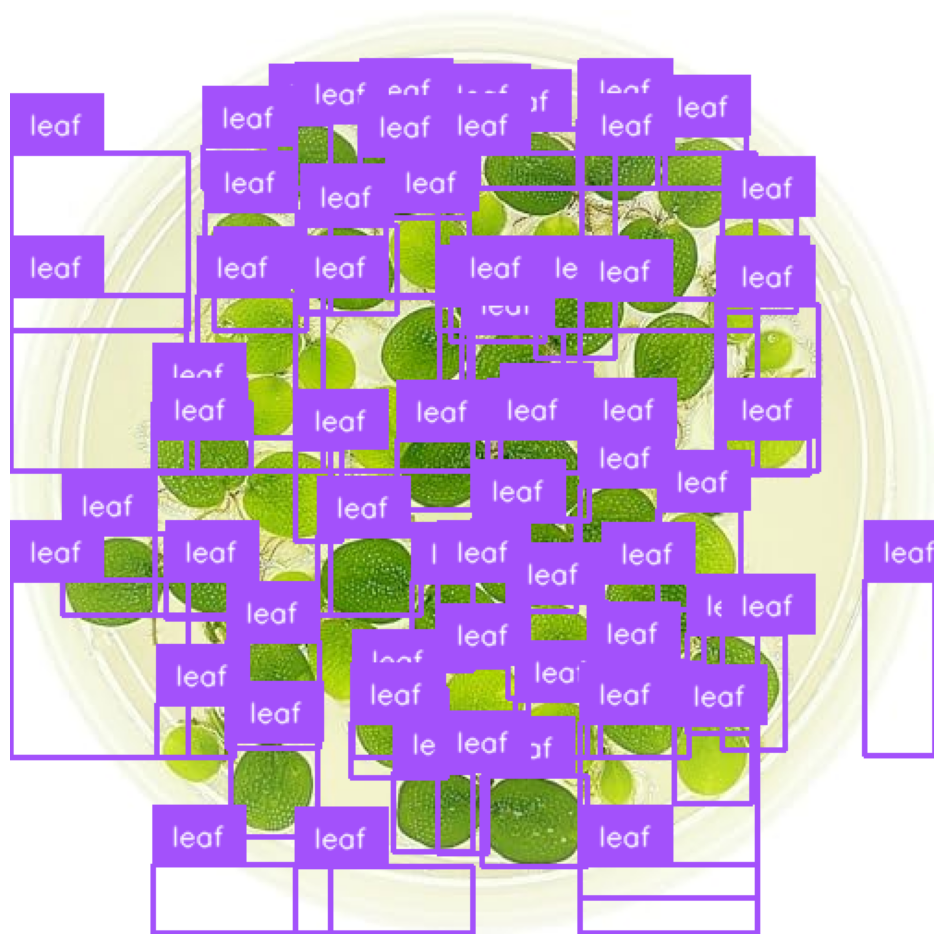

In [25]:
from roboflow import Roboflow
import supervision as sv
import numpy as np
import cv2
import tempfile
import os

API_KEY = os.environ["ROBOFLOW_API_KEY"]

rf = Roboflow(api_key=API_KEY)
project = rf.workspace().project("leaf-detection-h0stp")
model = project.version(1).model

def callback(image: np.ndarray) -> sv.Detections:
    with tempfile.NamedTemporaryFile(suffix=".jpg") as f:
        cv2.imwrite(f.name, image)
        result = model.predict(f.name, confidence=40, overlap=20).json()

    detections = sv.Detections.from_inference(result)
    return detections

image = cv2.imread("imgs/2.jpg")

slicer = sv.InferenceSlicer(callback=callback, slice_wh=(96, 96), overlap_ratio_wh=(0.2, 0.2))
sliced_detections = slicer(image=image)

prediction_count = len(sliced_detections.xyxy)
print(f"Counted {prediction_count} leafs")

label_annotator = sv.LabelAnnotator()
box_annotator = sv.BoxAnnotator()

annotated_frame = box_annotator.annotate(
    scene=image.copy(),
    detections=sliced_detections,
)

annotated_frame = label_annotator.annotate(
    scene=annotated_frame, detections=sliced_detections
)


sv.plot_image(image=annotated_frame)